In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window=20):
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        returns = group['return'].copy()
        q_low = returns.quantile(0.05)
        q_hi = returns.quantile(0.95)
        returns = returns.clip(lower=q_low, upper=q_hi)
        
        time_idx = np.arange(len(group))
        up_mask = returns > 0
        down_mask = returns < 0
        flat_mask = returns == 0
        
        if up_mask.any():
            up_weights = returns[up_mask].abs() * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        if down_mask.any():
            down_weights = returns[down_mask].abs() * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        if flat_mask.any():
            flat_weights = group.loc[flat_mask, 'volume'] * (
                1 - (group.loc[flat_mask, 'high'] - group.loc[flat_mask, 'low']).abs() / group.loc[flat_mask, 'open']
            )
            G_f = np.sum(time_idx[flat_mask] * flat_weights) / flat_weights.sum()
        else:
            G_f = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'G_f': G_f
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna(subset=['G_u', 'G_d'])
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        X = train_data[['G_u']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 市场状态识别
    volatility = daily_df['G_d'].diff().abs().rolling(5).std()
    trend_strength = daily_df['residual'].rolling(5).mean() / daily_df['residual'].rolling(5).std()
    
    # 状态调整因子
    daily_df['raw_factor'] = daily_df['residual'].rolling(window).mean()
    daily_df['factor'] = np.where(
        volatility > volatility.quantile(0.7),
        trend_strength * daily_df['raw_factor'],  # 高波动期放大趋势信号
        daily_df['raw_factor']  # 低波动期保持原值
    )
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.024491
   Rank_IC (Spearman): 0.018633
📊 信息比率:
   IR: 0.125981
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


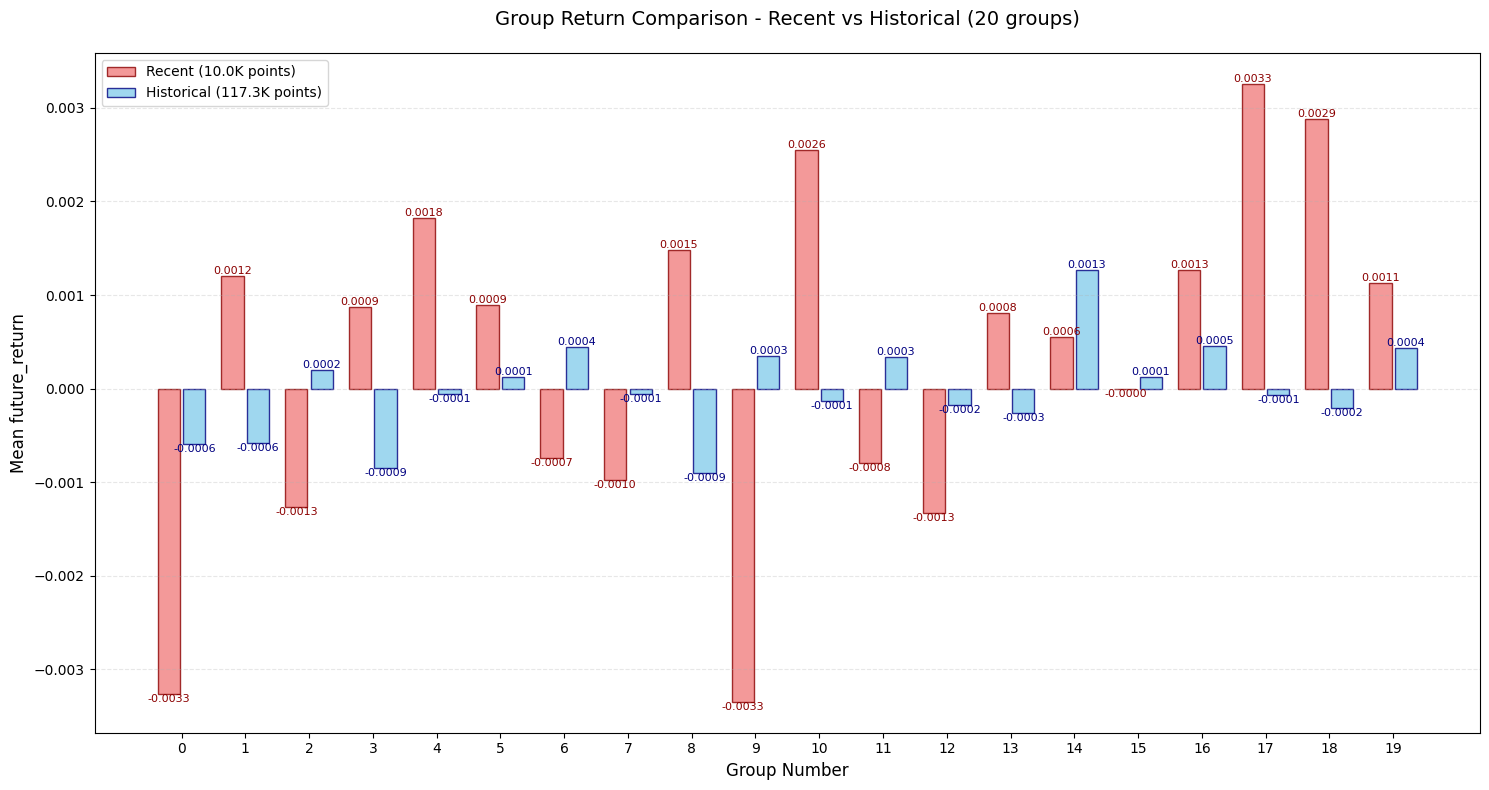

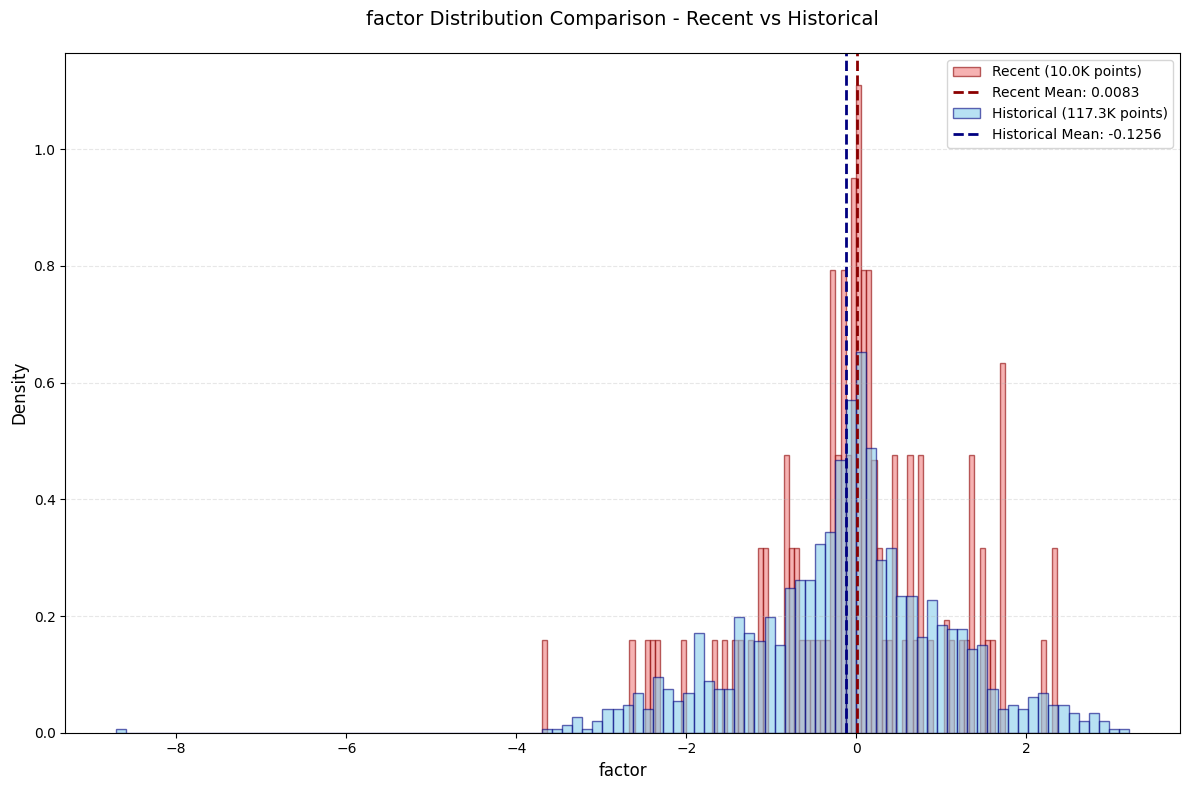

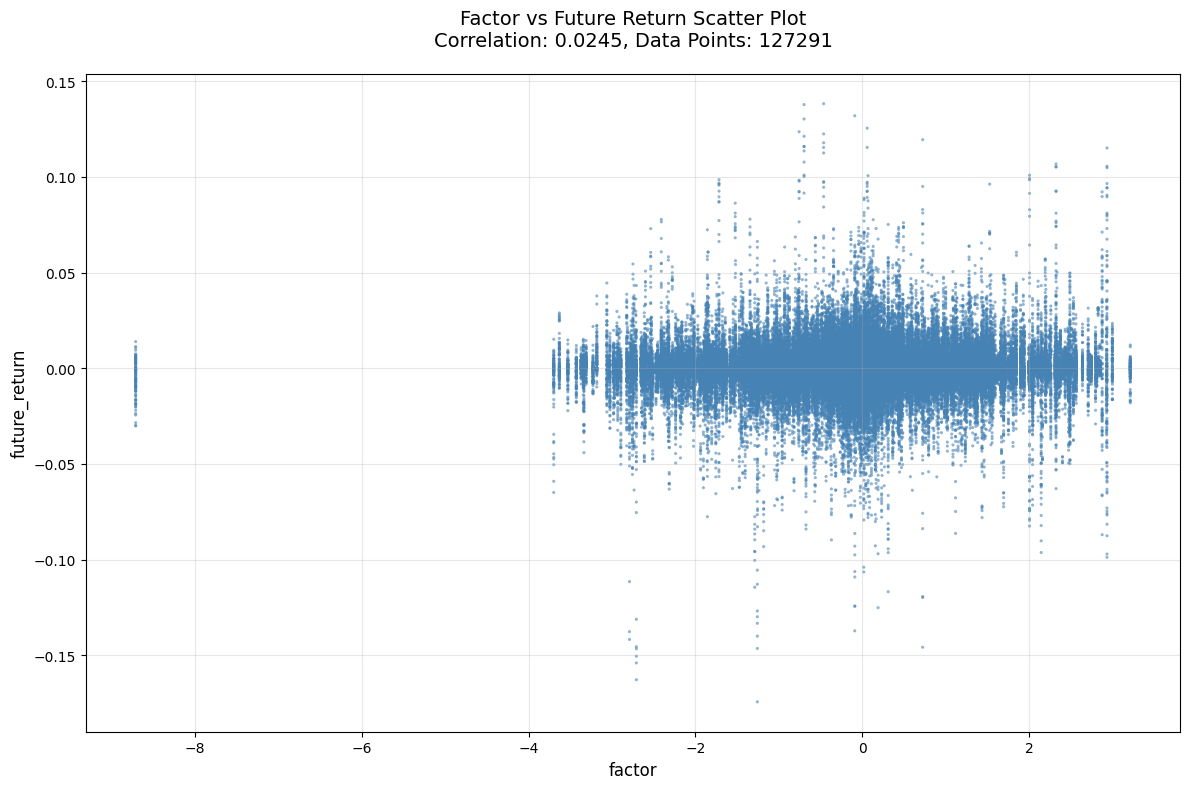

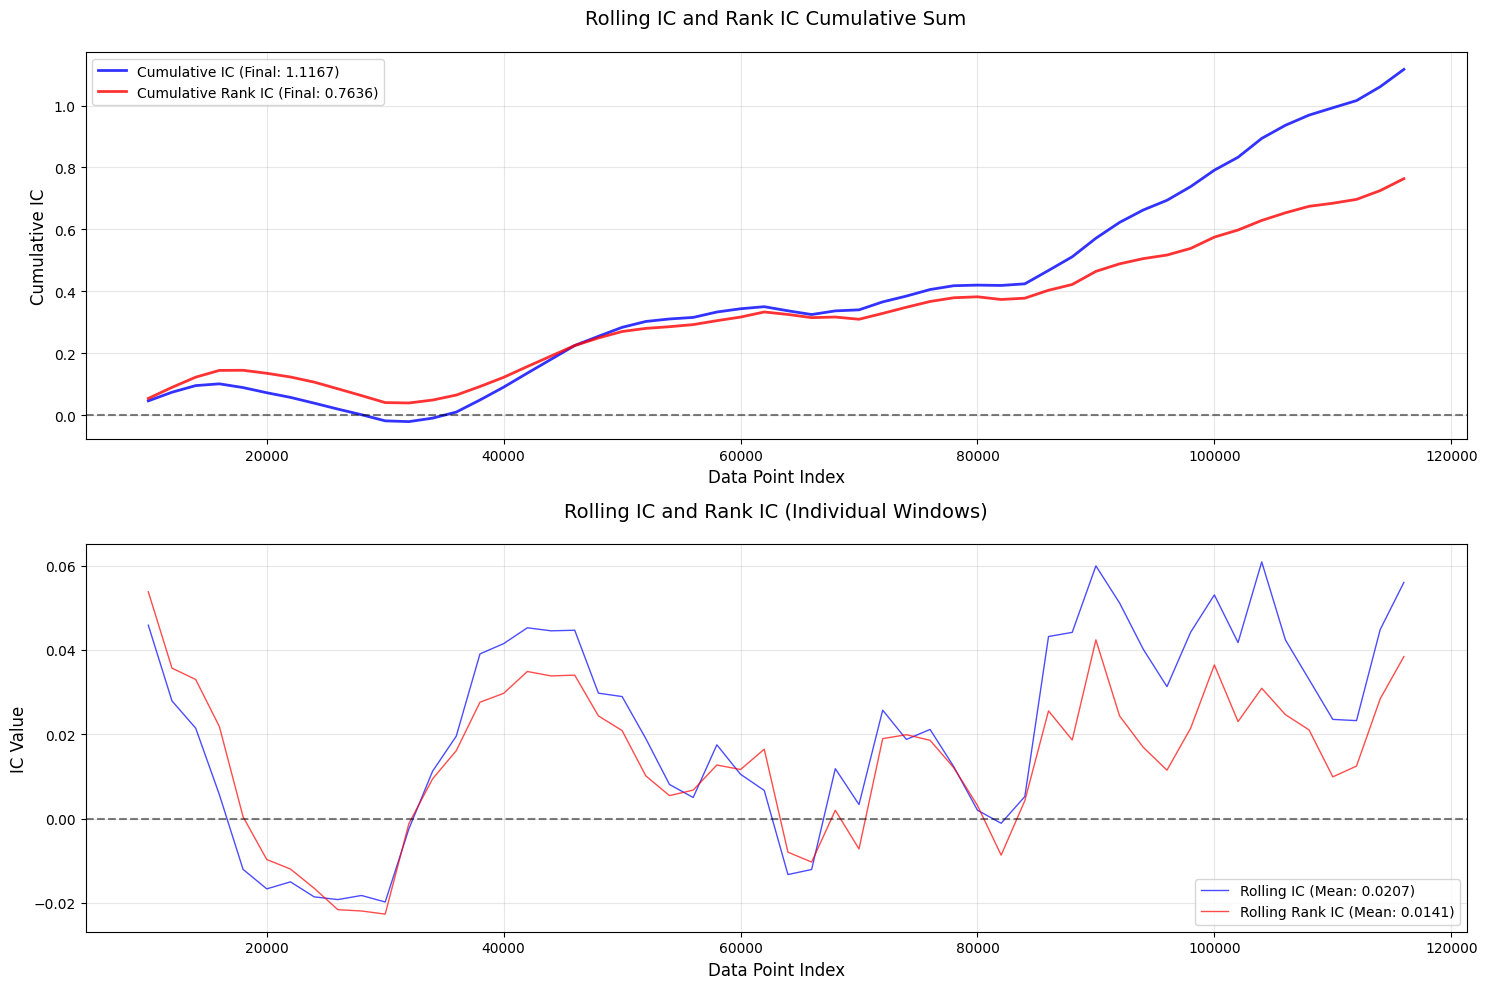

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.04210176913374548,
 -0.010795411714912632,
 0.009753409420775164,
 -0.04897378708529003,
 0.026839731933406986,
 0.05366162604996839,
 0.008301453645192282,
 -0.05278066633330745,
 0.00634987688677893,
 0.00685513067982096]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.024491216182909763, 'Rank_IC': 0.018633470910374844}, 'information_ratio': {'IR': 0.1259807233069346, 'group_correlations': [0.04210176913374548, -0.010795411714912632, 0.009753409420775164, -0.04897378708529003, 0.026839731933406986, 0.05366162604996839, 0.008301453645192282, -0.05278066633330745, 0.00634987688677893, 0.00685513067982096], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -8.7094  -2.2737   -2.8040      -0.0008      0.0128   6432
1      -2.2380  -1.7055   -1.9433      -0.0003      0.0113   6336
2      -1.6869  -1.2770   -1.4423      -0.0002      0.0110   6336
3      -1.2746  -0.9821   -1.1277      -0.0006      0.0121   6432
4      -0.9794  -0.7387   -0.8423      -0.0000      0.0114   6336
5      -0.7367  -0.5424   -0.6430      -0.0000      0.0116   6336
6      -0.5388  -0.3680   -0.4435       0.00